Import modules

In [1]:
from lib.datasets import get_stock_price,train_test_split
from lib.aug import apply_augmentations,parse_augmentations,sig_normal
import torch
from torch import nn
import torch.nn.functional as F
from lib.utils import set_seed
import signatory
from models.vae import VAE, VAE_train
from models.betavae import BetaVAE, BetaVAE_train
from models.infovae import InfoVAE, InfoVAE_train
from models.wae import WAE,WAE_train
from lib.metrics import mmd_loss,SignatureKernel,RBFKernel

In [2]:
set_seed(0)

The considered truncated signature degree.

In [3]:
sig_degree = [3,4,5]

In [4]:
data_config = {
    "ticker" : "^GSPC",
    "interval" : "1d",
    "column" : 1,  
    "window_size" : 20,
    "dir" : "datasets",
    "subdir" : "stock"
}
sig_config = {
    "augmentations": [{"name": "LeadLag"}],
    "device" : "cuda",
    "depth" : sig_degree[0], # degree = 4
}

Get path augmentations.

In [5]:
if sig_config["augmentations"] is not None:
    sig_config["augmentations"] = parse_augmentations(sig_config.get('augmentations'))

Data preprocessing.
- Split training data and testing data.
- Apply path augmentations to original path.
- Calculate signature.
- Normalize signatures.
- Pass to CUDA.

In [6]:
tensor_data = get_stock_price(data_config)
x_real_train, x_real_test = train_test_split(tensor_data, train_test_ratio=0.8, device=sig_config["device"])
print("x_real_train shape {}, x_real_test shape {}".format(x_real_train.shape,x_real_test.shape))

if sig_config["augmentations"] is not None:
    # Print the tensor shape after each augmentation
    x_aug_train, x_aug_test = apply_augmentations(x_real_train,sig_config["augmentations"]), apply_augmentations(x_real_test,sig_config["augmentations"])
print("After augmentation shape:",x_aug_train.shape)

# To signature
x_sig_train, x_sig_test = signatory.signature(x_aug_train,sig_config["depth"]),signatory.signature(x_aug_test,sig_config["depth"])
print("x_sig_train shape {}, x_sig_test shape {}".format(x_sig_train.shape,x_sig_test.shape))
input_dim = x_sig_train.shape[1]
print("input_dim: {}".format(input_dim))

# Normalize
x_sig_train, x_sig_test = sig_normal(x_sig_train,True), sig_normal(x_sig_test,True)

# To device
x_sig_train, x_sig_test = x_sig_train.to(sig_config["device"]), x_sig_test.to(sig_config["device"])

Rolled data for training, shape torch.Size([1232, 20, 1])
x_real_train shape torch.Size([985, 20, 1]), x_real_test shape torch.Size([247, 20, 1])
torch.Size([985, 39, 2])
torch.Size([247, 39, 2])
After augmentation shape: torch.Size([985, 39, 2])
x_sig_train shape torch.Size([985, 14]), x_sig_test shape torch.Size([247, 14])
input_dim: 14


In [7]:
# For degree = 3
hidden_dim_degree3 = [input_dim,7,3] # input_dim = 14

# For degree = 4
hidden_dim_degree4 = [input_dim,15,7] # input_dim = 30

# For degree = 5
hidden_dim_degree5 = [input_dim,32,16] # input_dim = 62

Set degree = 4. Initialize models.

In [8]:
# VAE
model_vae = VAE(x_aug_sig=x_sig_train,epoch=6000,batch_size=128,device="cuda",hidden_dims=hidden_dim_degree3)
vae_optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-4)
VAE_train(model_vae,optimizer=vae_optimizer)

Input tensor shape: torch.Size([985, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 2.09
Epoch 100 loss 1.37
Epoch 200 loss 1.51
Epoch 300 loss 2.24
Epoch 400 loss 1.36
Epoch 500 loss 1.56
Epoch 600 loss 1.35
Epoch 700 loss 1.28
Epoch 800 loss 1.45
Epoch 900 loss 1.96
Epoch 1000 loss 1.98
min_loss: 1.22


In [9]:
# Beta-VAE
model_betavae = BetaVAE(x_sig_train,6000,128,beta=3.5,device='cuda',hidden_dims=hidden_dim_degree3)
beta_optimizer = torch.optim.Adam(model_betavae.parameters(), lr=1e-4)
BetaVAE_train(model=model_betavae,optimizer=beta_optimizer)

Input tensor shape: torch.Size([985, 14])
Hidden dims: [14, 7, 3]
Beta: 3.5
Epoch 0 loss 19.97
Epoch 100 loss 29.19
Epoch 200 loss 20.69
Epoch 300 loss 32.93
Epoch 400 loss 18.91
min_loss: 17.04


In [10]:
# Info-VAE
model_infovae = InfoVAE(x_aug_sig=x_sig_train,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
info_optimizer = torch.optim.Adam(model_infovae.parameters(), lr=1e-4) 
InfoVAE_train(model_infovae,info_optimizer)

Input tensor shape: torch.Size([985, 14])
Hidden dims: [14, 7, 3]
Epoch 0 loss 4.06
Epoch 100 loss 2.23
Epoch 200 loss 4.25
Epoch 300 loss 1.65
Epoch 400 loss 4.07
min_loss: 1.40


In [11]:
# WAE-MMD
model_waemmd = WAE(x_aug_sig=x_sig_train,epoch=6000,batch_size=128,hidden_dims=hidden_dim_degree3,device='cuda')
cvae_optimizer = torch.optim.Adam(model_waemmd.parameters(), lr=1e-4) 
WAE_train(model_waemmd,cvae_optimizer)

Epoch 0 loss 1.58
Epoch 100 loss 1.99
Epoch 200 loss 1.58
Epoch 300 loss 1.40
Epoch 400 loss 2.09
Epoch 500 loss 2.24
Epoch 600 loss 2.14
Epoch 700 loss 1.63
min_loss: 1.29


Evaluate.

In [12]:
KLD = nn.KLDivLoss(reduction="batchmean")
sigkernel = SignatureKernel(static_kernel=RBFKernel(sigma=1.0))

In [13]:
models = [model_vae,model_betavae,model_infovae,model_waemmd]
for model in models:
    _, _, z = model_vae.encode(x_sig_test)
    reconstructed_sig = model_vae.decode(z)
    reconstructed_sig = sig_normal(reconstructed_sig,True)

    # Mean of L2 norm over the batch dimension
    L2 = F.mse_loss(x_sig_test,reconstructed_sig)
    # Mean of JS divergence over the batch dimension
    js = (KLD(x_sig_test,reconstructed_sig)+KLD(reconstructed_sig,x_sig_test))/2
    # signature MMD
    mmd = mmd_loss(x_sig_test,reconstructed_sig,sigkernel)

    print("L2 ({}): {:.3f}".format(model.type,L2.item()))
    print("JS ({}): {:.3f}".format(model.type,js.item()))
    print("mmd ({}): {:.3f}".format(model.type,mmd.item()))

L2 (VAE): 1.955
JS (VAE): 0.043
mmd (VAE): 0.313
L2 (Beta-VAE): 1.980
JS (Beta-VAE): -0.013
mmd (Beta-VAE): 0.311
L2 (Info-VAE): 2.083
JS (Info-VAE): 0.394
mmd (Info-VAE): 0.311
L2 (WAE): 1.962
JS (WAE): 0.017
mmd (WAE): 0.315


Plot training loss.

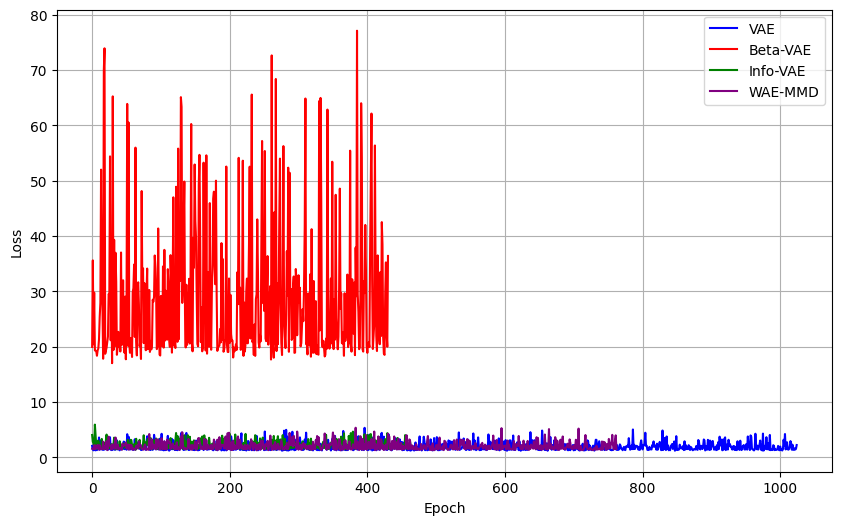

In [14]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

# Plot each model's loss with a different label and color
plt.plot(range(len(model_vae.loss_record)), model_vae.loss_record, label='VAE', color='blue')
plt.plot(range(len(model_betavae.loss_record)), model_betavae.loss_record, label='Beta-VAE', color='red')
plt.plot(range(len(model_infovae.loss_record)), model_infovae.loss_record, label='Info-VAE', color='green')
plt.plot(range(len(model_waemmd.loss_record)), model_waemmd.loss_record, label='WAE-MMD', color='purple')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Loss Curves for the stock dataset, $d=3$')
plt.legend()  # Add a legend to distinguish the models
plt.grid(True)  # Optional: adds a grid for better readability
plt.savefig('assets/loss/loss_stock_d3.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()